# Title

## Introduction

*Why we're doing this*

In [96]:
import os
#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

In [97]:
# todo: move these imports to the cells where they're actually needed
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers, activations, regularizers
import time

from IPython import display

## Dataset

*discuss Stanford Dogs dataset and loading process*

In [98]:
import tensorflow_datasets as tfds

dataset = tfds.load("stanford_dogs")

IMAGE_SIZE = 64

@tf.function
def process_image_flat(data):
    image = data['image']
    boxes = data['objects']['bbox']

    images_cropped = tf.image.crop_and_resize([image], boxes, tf.zeros(tf.shape(boxes)[0], dtype=tf.dtypes.int32), [IMAGE_SIZE, IMAGE_SIZE])
    images_scaled = (images - 127.5) / 127.5

    return tf.data.Dataset.from_tensor_slices(images_scaled)

@tf.function
def process_image(data):
    image = data['image']
    boxes = data['objects']['bbox']

    image_cropped = tf.image.crop_and_resize([image], [boxes[0]], [0], [IMAGE_SIZE, IMAGE_SIZE])[0]
    image_norm = (image_cropped - tf.reduce_min(image_cropped))
    image_norm = image_norm / tf.reduce_max(image_norm)
    image_scaled = image_norm * 2 - 1

    return image_scaled

@tf.function
def correct_box(img_shape, box):
    rel_height = box[0] - box[2]
    abs_height = rel_height * img_shape[0]
    rel_width = box[1] - box[3]
    abs_width = rel_width * img_shape[1]
    
    aspect = tf.math.maximum(abs_box_height) / tf.math.maximum(abs_box_width, 1)
    
    if aspect > 1:
        height_offset = rel_height - (rel_height / aspect)
        return [box[0] - height_offset, box[1], box[2] + height_offset, box[3]]
    elif aspect < 1:
        width_offset = rel_width - (rel_width * aspect)
        return [box[0], box[1] - width_offset, box[2], box[3] + width_offset]
        
    return box
    

def is_roughly_bw(img):
    bw = tf.math.reduce_mean(img, axis=2)
    bw = tf.stack([bw, bw, bw], axis=2)
    return tf.math.reduce_mean(tf.math.abs(img - bw)) < 0.05

train_images = dataset['train'].concatenate(dataset['test']).map(process_image) #.filter(is_roughly_bw)
train_images = train_images.shuffle(buffer_size=train_images.cardinality(), reshuffle_each_iteration=True) # from tf.Dataset.shuffle docs 

*Write more eloquently worded text saying we can preview the dogs:*

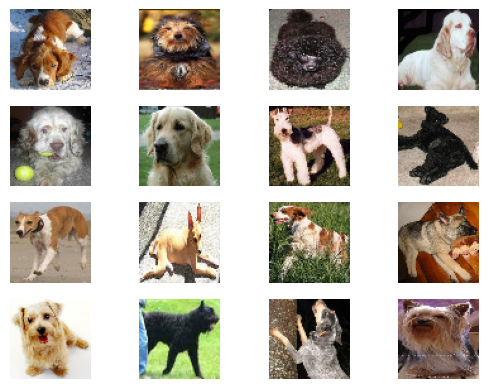

In [99]:
import matplotlib.pyplot as plt

preview_rows = 4
for i, data in enumerate(train_images.take(preview_rows ** 2)):
    plt.subplot(preview_rows, preview_rows, i+1)
    plt.imshow((data.numpy() + 1) / 2)
    plt.axis('off')

In [100]:
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
BATCH_SIZE=64
train_dataset = train_images.batch(BATCH_SIZE) #shuffle(BUFFER_SIZE).

## Generator

*describe purpose*

In [101]:
def make_generator_model(transpose=True):
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=True, input_shape=(128,)))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Reshape([8,8,512]))
    assert model.output_shape == (None, 8, 8, 512) # None is batch size

    add_conv_layer(model, 256, upscale=True, transpose=transpose)
    assert model.output_shape == (None, 16, 16, 256)

    add_conv_layer(model, 128, upscale=True, transpose=transpose)
    assert model.output_shape == (None, 32, 32, 128)
    
    add_conv_layer(model, 64, upscale=True, transpose=transpose)
    assert model.output_shape == (None, 64, 64, 64)
    
    add_conv_layer(model, 3, upscale=False, transpose=False, final=True)
    assert model.output_shape == (None, 64, 64, 3)
    return model

*discuss generator architecture*

In [102]:
def add_conv_layer(model, n, upscale=False, final=False, transpose=False):
    conv_options = {
        'padding': 'same',
        #'use_bias': True,
        'activation': 'tanh' if final else None,
        #'kernel_regularizer': 'l2',
        #'bias_regularizer': 'l2',
    }
    kernel_size = (4, 4)
    
    if transpose:
        strides = (2, 2) if upscale else (1, 1)
        model.add(layers.Conv2DTranspose(n, kernel_size, strides=strides, **conv_options))
    else:
        if upscale:
            model.add(layers.UpSampling2D(size=(2,2), interpolation='bilinear'))
        model.add(layers.Conv2D(n, kernel_size, **conv_options))
        
    if not final:
        #model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

def make_l2():
    return regularizers.L2()

*discuss transposed-convolution vs. upscaling, purpose of BatchNormalization and leaky ReLU activation function*

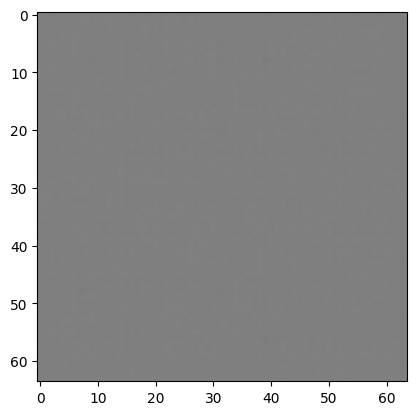

In [103]:
generator = make_generator_model()

noise = tf.random.normal([1, 128])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0, :, :, :] + 1) / 2)

## Discriminator

*describe purpose*

In [104]:
def make_discriminator_model(const=None):
    
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
        input_shape=[64, 64, 3], kernel_constraint=const))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))
    assert model.output_shape == (None, 32, 32, 64)

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_constraint=const))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))
    assert model.output_shape == (None, 16, 16, 128)

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_constraint=const))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(0.3))
    assert model.output_shape == (None, 8, 8, 128)

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, kernel_constraint=const))

    return model

In [105]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.0004737]], shape=(1, 1), dtype=float32)


## Training

*words words words...*

In [106]:
EPOCHS = 500
noise_dim = 128
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim]) # TODO: move this

*What are GradientTapes? Why is training approached this way? Discuss. This page has some more information we could cite (in our own words of course): https://keras.io/guides/writing_a_training_loop_from_scratch/*

In [107]:
class GAN:
    def __init__(self):
        self.generator_loss_epoch = []
        self.discriminator_loss_epoch = []

    @tf.function
    def train_step(self, images, batch_num):
        train_generator = ((batch_num % self.generator_interval) == 0)
        
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
        with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
            generated_images = self.generator(noise, training=True)
    
            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
    
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)
    
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
    
        if train_generator:
            gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
    
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
    
        return gen_loss, disc_loss

*Describe the training process per epoch.*

In [108]:
def train(dataset, epochs, model):
    model.checkpoint_dir = './training_checkpoints'
    model.checkpoint_prefix = os.path.join(model.checkpoint_dir, "ckpt")
    model.checkpoint = tf.train.Checkpoint(generator_optimizer=model.generator_optimizer,
                                 discriminator_optimizer=model.discriminator_optimizer,
                                 generator=model.generator,
                                 discriminator=model.discriminator)

    for epoch in range(epochs):
        start = time.time()

        gen_loss_batch = []
        disc_loss_batch = []

        for batch_num, image_batch in enumerate(dataset):
            if tf.shape(image_batch)[0] != BATCH_SIZE: # skip partial batches
                continue

            gen_loss_value, disc_loss_value = model.train_step(image_batch, tf.constant(batch_num, dtype=tf.dtypes.int32))
            
            gen_loss_batch.append(gen_loss_value)
            disc_loss_batch.append(disc_loss_value)

        model.generator_loss_epoch.append(np.mean(gen_loss_batch))
        model.discriminator_loss_epoch.append(np.mean(disc_loss_batch))
        
        display.clear_output(wait=True)
        print("Time for epoch {} is {} sec".format(epoch + 1, time.time()-start))
        
        generate_and_save_images(model, epoch + 1, seed)

        if (epoch + 1) % 15 == 0:
            model.checkpoint.save(file_prefix = model.checkpoint_prefix)

        plot_loss(model)
        

    display.clear_output(wait=True)
    generate_and_save_images(model, epochs, seed)
    
    plot_loss(model, True)

*The image saving part isn't that interesting, but if there's something to discuss, put it here*

In [109]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.generator(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2)
        plt.axis('off')

    plt.savefig('{}_image_at_epoch_{:04d}.png'.format(model.name, epoch))
    plt.show()

*What does plotting the loss functions do for us? Describe it*

In [87]:
def plot_loss(model, save=False):
    plt.plot(range(len(model.generator_loss_epoch)), model.generator_loss_epoch, label = "Generator Loss")
    plt.plot(range(len(model.discriminator_loss_epoch)), model.discriminator_loss_epoch, label = "Discriminator Loss")
    plt.title(model.name + " Loss Per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Mean Batch Loss")
    plt.legend()
    
    if save:
        plt.savefig("loss_epochs_{}_{}.png".format(len(generator_loss_epoch), model_name))
    plt.show()

## Minimax GAN
*describe Minimax GAN*

In [88]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

class Minimax(GAN):
    def __init__(self):
        self.generator = make_generator_model()
        self.discriminator = make_discriminator_model(None)
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.name = "Minimax"
        self.generator_interval = 1
        super().__init__()
    
    def discriminator_loss(self, real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    
    def generator_loss(self, fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
minimax = Minimax()

Time for epoch 3 is 32.10799503326416 sec


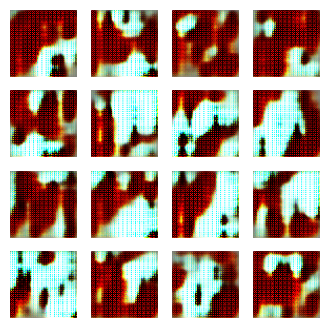

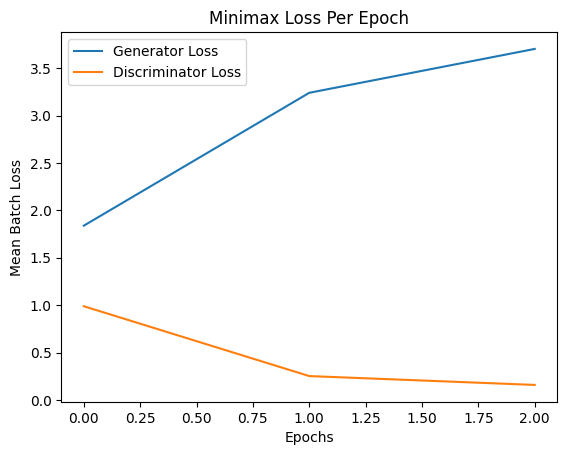

KeyboardInterrupt: 

In [89]:
train(train_dataset, EPOCHS, minimax)

*discuss Minimax results*

## Wasserstein GAN

*describe purpose, difference from minimax. Why is the discriminator termed the "critic"?*

In [90]:
# taken from Machine Learning Mastery Wasserstein tutorial
from tensorflow.keras import constraints, backend

# clip model weights to a given hypercube
class ClipConstraint(constraints.Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}

*Discuss the ClipConstraint and loss functions.*

In [110]:
class Wasserstein(GAN):
    def __init__(self):
        self.generator = make_generator_model()
        self.discriminator = make_discriminator_model(ClipConstraint(0.01))
        self.generator_optimizer = tf.keras.optimizers.experimental.RMSprop(5e-5)
        self.discriminator_optimizer = tf.keras.optimizers.experimental.RMSprop(5e-5)
        self.name = "Wasserstein"
        self.generator_interval = 5
        super().__init__()

    def discriminator_loss(self, real_output, fake_output):
        return tf.reduce_mean([-real_output, fake_output])

    def generator_loss(self, fake_output):
        return tf.reduce_mean(-fake_output)

In [111]:
wass = Wasserstein()

Time for epoch 420 is 21.995890617370605 sec


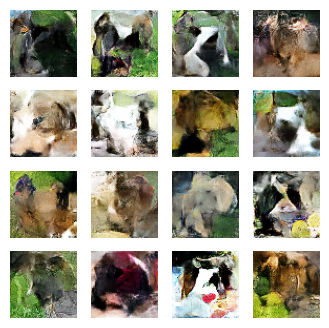

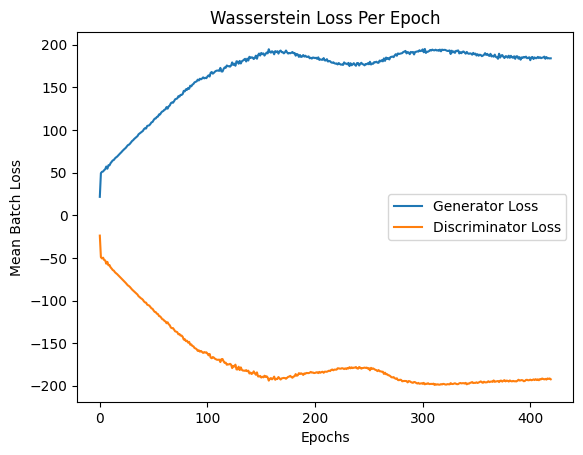

In [ ]:
train(train_dataset, EPOCHS, wass)

In [ ]:
wass.checkpoint.restore(tf.train.latest_checkpoint(wass.checkpoint_dir))

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

- https://www.tensorflow.org/tutorials/generative/dcgan
- https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/
- https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/
- https://stackoverflow.com/a/42121886